In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

import kagglehub
import random
import itertools


In [ ]:


class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        # Convolutional Block 3
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        # Convolutional Block 4
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 3 * 3, 64)  # Adjust input size based on the final feature map size
        self.bn9 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 64)
        self.bn10 = nn.BatchNorm1d(64)
        self.dropout6 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Fully Connected Layers
        x = self.flatten(x)
        x = F.relu(self.bn9(self.fc1(x)))
        x = self.dropout5(x)

        x = F.relu(self.bn10(self.fc2(x)))
        x = self.dropout6(x)

        x = self.fc3(x)
        return F.softmax(x, dim=1)

# Create an instance of the model
model = CNNModel(num_classes=7)

# Load the saved state dictionary
model.load_state_dict(torch.load('/content/ModelFinal_detection_model.pth'))

# Set the model to evaluation mode
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [ ]:

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

100%|██████████| 65.2M/65.2M [00:00<00:00, 72.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1


In [ ]:


# Define the paths to your train and test directories
train_dir = path+ '/train'  # Replace with your actual train directory path
test_dir = path+'/test'    # Replace with your actual test directory path

# Function to count images in each category
def count_images_per_category(directory):
    category_counts = {}
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            image_count = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
            category_counts[category] = image_count
    return category_counts

# Count images in train and test directories
train_counts = count_images_per_category(train_dir)
test_counts = count_images_per_category(test_dir)

# Print the results
for category, count in train_counts.items():
    print(f"{category}: {count}")

for category, count in test_counts.items():
    print(f"{category}: {count}")


happy: 7215
angry: 3995
surprised: 3171
disgusted: 436
fearful: 4097
sad: 4830
neutral: 4965
happy: 1774
angry: 958
surprised: 831
disgusted: 111
fearful: 1024
sad: 1247
neutral: 1233


In [ ]:
root_dir = path
train_dir = root_dir + '/train'
test_dir = root_dir + '/test'

In [ ]:
target_var = os.listdir(train_dir)
print(target_var)

['neutral', 'disgusted', 'happy', 'surprised', 'sad', 'angry', 'fearful']


In [ ]:

# ... (Your existing code) ...

disgusted_dir = '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train/disgusted'
disgusted_images = [f for f in os.listdir(disgusted_dir) if os.path.isfile(os.path.join(disgusted_dir, f))]
num_disgusted_images = len(disgusted_images)

target_images = 2000

if num_disgusted_images < target_images:
    images_to_generate = target_images - num_disgusted_images
    print(f"Augmenting {images_to_generate} images for the 'disgusted' class.")

    # Perform data augmentation (example using random horizontal flips)
    for i in range(images_to_generate):
      random_image = random.choice(disgusted_images)
      image_path = os.path.join(disgusted_dir, random_image)
      try:
        img = Image.open(image_path)
        # Apply augmentation here (e.g., random horizontal flip, rotation, etc.)
        augmented_img = transforms.RandomHorizontalFlip(p=1)(img) # Example augmentation

        new_filename = f"augmented_{i}_{random_image}"
        augmented_image_path = os.path.join(disgusted_dir, new_filename)
        augmented_img.save(augmented_image_path)
      except Exception as e:
        print(f"Error augmenting image: {image_path}. Error: {e}")

    print(f"Data augmentation complete. Check the 'disgusted' directory.")
else:
    print("'disgusted' class already has enough images.")


Augmenting 1564 images for the 'disgusted' class.
Data augmentation complete. Check the 'disgusted' directory.


In [ ]:
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("GPU is NOT available. Using CPU.")

if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Use CPU
    print("Using CPU")

GPU is NOT available. Using CPU.
Using CPU


In [ ]:


train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Split train dataset into training and validation sets
train_size = int(0.7 * len(train_dataset))  # 70% training, 30% validation
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Define data loaders
batch_size = 64

train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)

# Print class names
print(train_dataset.classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:


disgusted_dir = '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train/disgusted'
disgusted_images = [f for f in os.listdir(disgusted_dir) if os.path.isfile(os.path.join(disgusted_dir, f))]
num_disgusted_images = len(disgusted_images)

print(f"There are {num_disgusted_images} 'disgusted' images in the training data.")


There are 2000 'disgusted' images in the training data.


In [ ]:


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Define loss function s
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.0005

train_loader = DataLoader(
    train_subset,
    batch_size=128,
    shuffle=True,  # Use shuffle instead of sampler
    num_workers=4,
    pin_memory=True
)

# Training loop
num_epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate validation metrics
    val_loss = val_running_loss / len(valid_loader)
    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training finished.")

Using device: cpu
Epoch [1/3], Train Loss: 1.5542, Train Acc: 60.84%, Val Loss: 1.5054, Val Acc: 65.72%
Epoch [2/3], Train Loss: 1.5301, Train Acc: 63.39%, Val Loss: 1.4873, Val Acc: 67.66%
Epoch [3/3], Train Loss: 1.5229, Train Acc: 64.20%, Val Loss: 1.4931, Val Acc: 66.97%
Training finished.


In [ ]:

torch.save(model.state_dict(), 'ModelFinal_detection_model.pth')


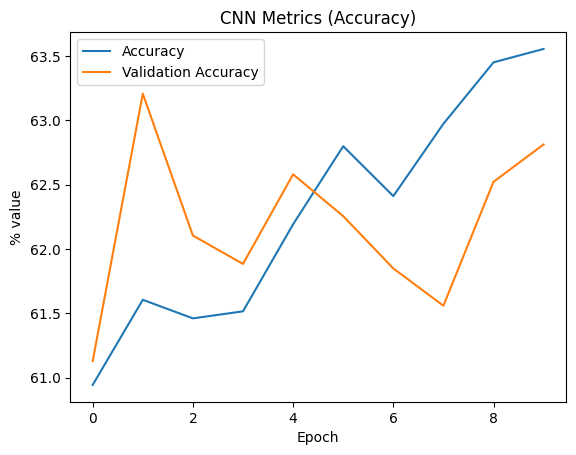

In [ ]:
# Plot training and validation accuracy
plt.plot(train_accuracies, label='Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

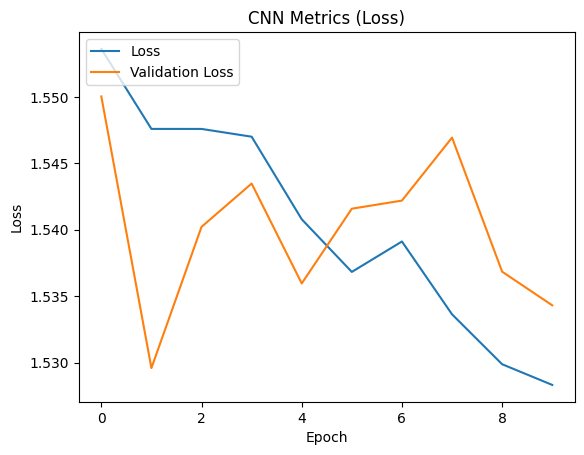

In [ ]:
# Plot training and validation loss
plt.plot(train_losses, label='Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('CNN Metrics (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.eval()

# Disable gradient computation
y_preds = []  # List to store all predictions
y_true = []   # List to store all true labels

with torch.no_grad():
    for inputs, labels in test_loader:  # Iterate over the test_loader
        # Move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass: compute predictions
        outputs = model(inputs)

        # If using a classification model, get the predicted class labels
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Collect predictions and true labels
        y_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
        y_true.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy

# Convert lists to numpy arrays
y_pred = np.array(y_preds)
y_true = np.array(y_true)

print("Predictions:", y_pred)
print("True Labels:", y_true)

Predictions: [5 5 0 ... 6 6 5]
True Labels: [0 0 0 ... 6 6 6]


In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# Extract true labels from the test dataset
y_actual = [label for _, label in test_dataset]
y_actual = np.array(y_actual)

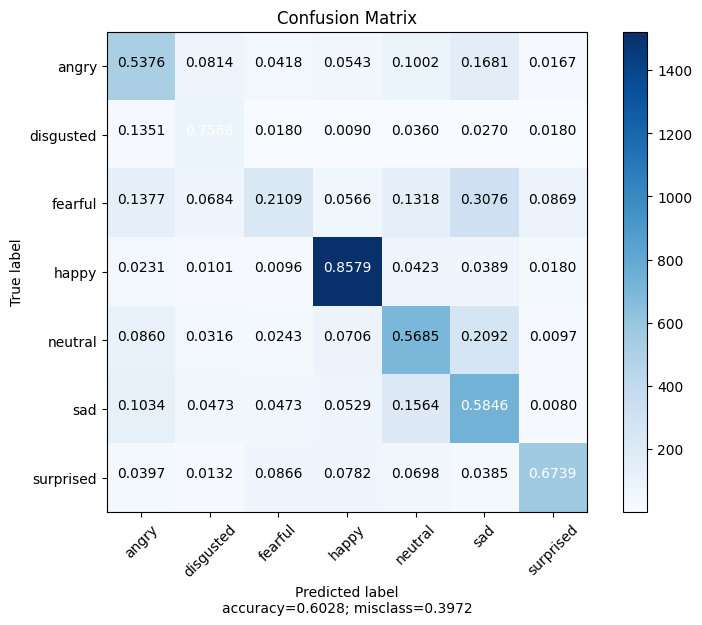

In [ ]:

class_names = train_dataset.classes

# Compute confusion matrix
cm = metrics.confusion_matrix(y_actual, y_pred)

# Use the custom plot_confusion_matrix function with class_names
plot_confusion_matrix(cm, target_names=class_names, title='Confusion Matrix', normalize=True)

In [ ]:

# Assuming 'model' and 'test_loader' are defined as in your provided code.


model.eval()  # Set the model to evaluation mode

y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy}")

print(classification_report(y_true, y_pred, target_names=train_dataset.classes))


Test Accuracy: 0.6028141543605461
              precision    recall  f1-score   support

       angry       0.53      0.54      0.53       958
   disgusted       0.23      0.76      0.36       111
     fearful       0.50      0.21      0.30      1024
       happy       0.82      0.86      0.84      1774
     neutral       0.55      0.57      0.56      1233
         sad       0.47      0.58      0.52      1247
   surprised       0.78      0.67      0.72       831

    accuracy                           0.60      7178
   macro avg       0.55      0.60      0.55      7178
weighted avg       0.61      0.60      0.60      7178



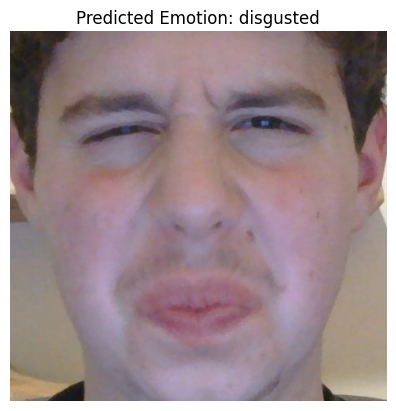

In [ ]:

# Assuming 'model', 'device', and 'train_dataset' are defined as in your previous code

# Define the image transformations (should be the same as used for training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image_path = "/content/disgust.png"
img = Image.open(image_path)
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device


# Make the prediction
with torch.no_grad():
    output = model(img_tensor)
    _, predicted_class = torch.max(output, 1)

# Get the predicted emotion label
predicted_emotion = train_dataset.classes[predicted_class.item()]

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()
